# gpOptimizer: Single-Task

In [1]:
##first, install the right version of gpCAM
#!pip install gpcam==8.1.10

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time


%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Prep

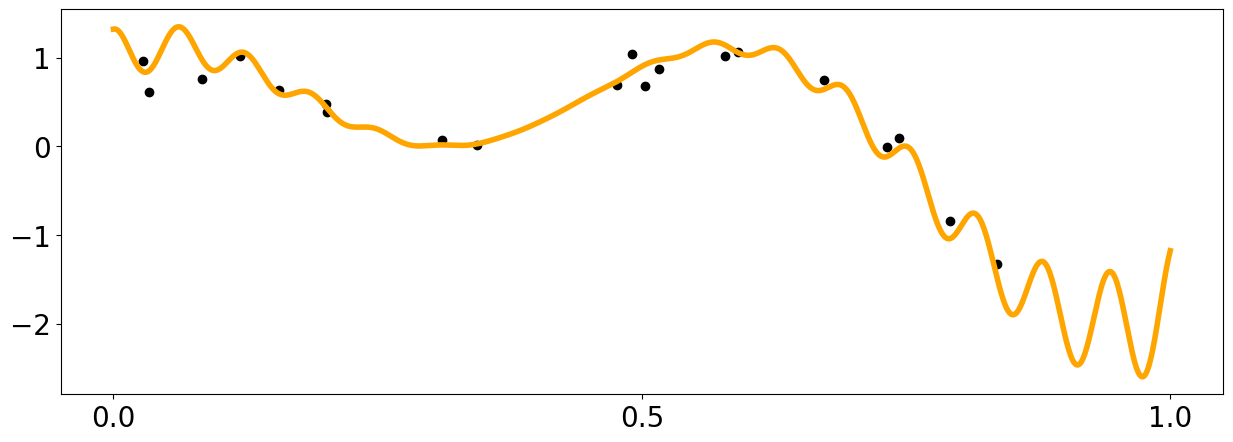

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(20).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

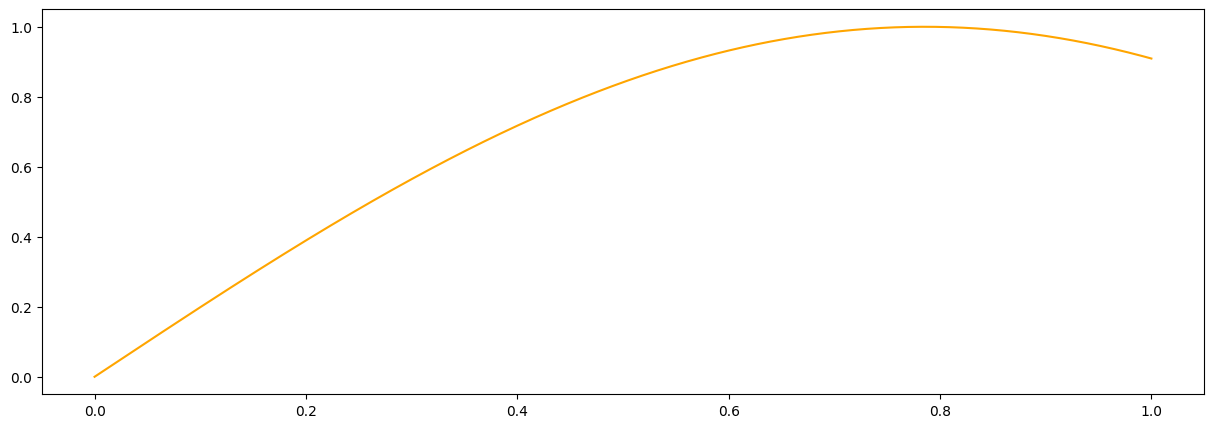

In [5]:
from gpcam.gp_kernels import *
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.zeros((len(x))) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [6]:


my_gp1 = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,1.],  #noise
                       [0.01,1.]  #mean
                      ])


my_gp1.tell(x_data, y_data, noise_variances=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gp1.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("MCMC Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
hps:  [1.2307413  0.28624809 0.26106277 0.01000545]
Local Training
[1.23070343 0.28662314 0.26106277 0.01000542]
MCMC Training
HGDL Training


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp_training.py:234: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  OptimumEvaluation = minimize(
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


array([1.23214765, 0.28678201, 0.40696869, 0.01      ])

In [7]:
my_gp1.get_data()

{'input dim': 1,
 'x data': array([[0.3438741 ],
        [0.02826643],
        [0.03375649],
        [0.8356897 ],
        [0.08415385],
        [0.50303209],
        [0.51578675],
        [0.74372027],
        [0.47622934],
        [0.20098424],
        [0.67196591],
        [0.12003693],
        [0.79120219],
        [0.15648953],
        [0.57877859],
        [0.31082619],
        [0.49099602],
        [0.2025159 ],
        [0.73203235],
        [0.59069686]]),
 'y data': array([ 0.01742736,  0.95801609,  0.60853453, -1.32596752,  0.75280326,
         0.6783561 ,  0.86933698,  0.09806053,  0.68948238,  0.47685961,
         0.7499799 ,  1.01815961, -0.83985253,  0.6350515 ,  1.01922829,
         0.0709612 ,  1.04047815,  0.39133565, -0.01300094,  1.06140081]),
 'measurement variances': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
 'hyperparameters': array([1.23214765, 0.28678201, 0.40696869, 0

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [8]:
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds)
for i in range(10):
    time.sleep(1)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.get_hyperparameters())
    print("")
my_gp1.stop_training(opt_obj)

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]

[1.23214764 0.28678211 0.40696869 0.01      ]



## Plotting the Result

0.2513673257298501
(np.float64(0.9554574379610923), np.float64(0.8543965312803072))


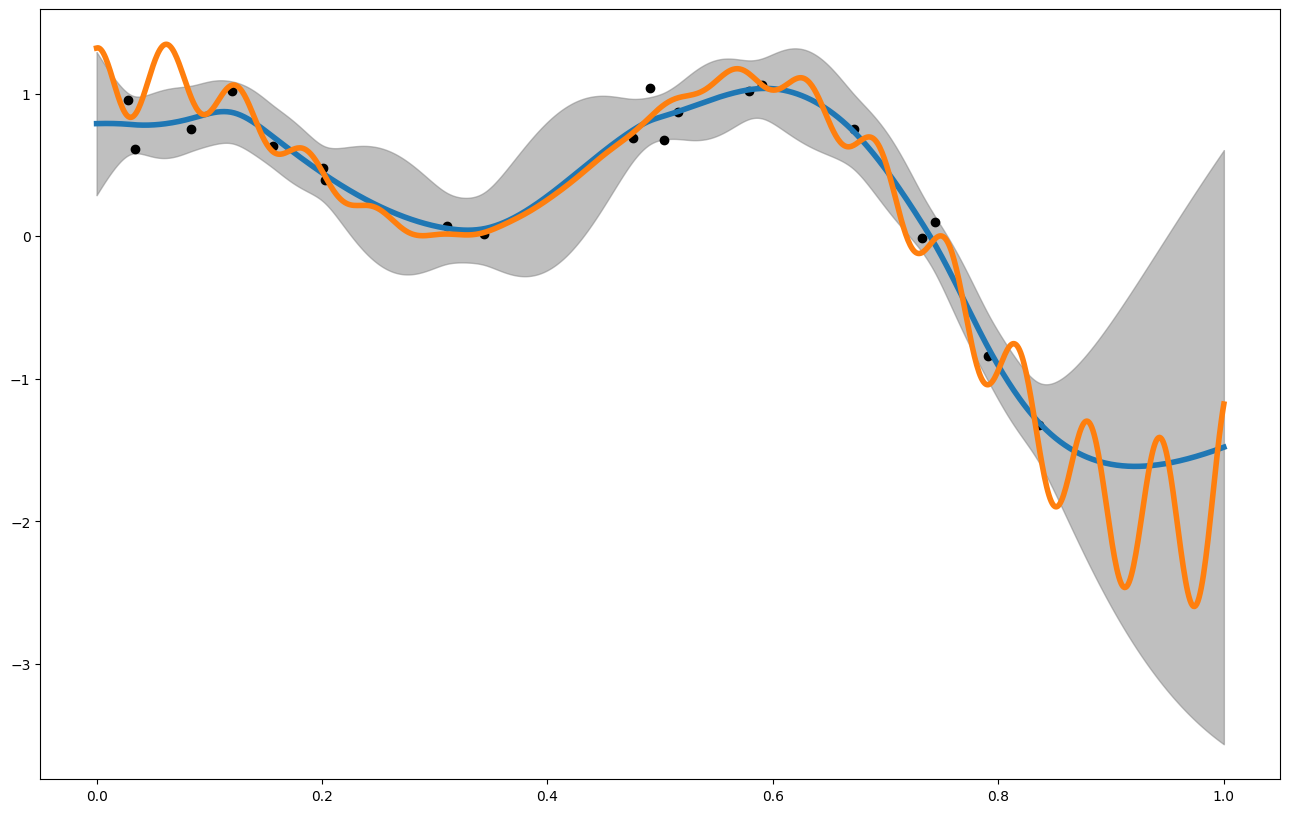

In [9]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,f1(x_pred1D)))
print(my_gp1.crps(x_pred1D,f1(x_pred1D)))

In [10]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("Mutual Information: ",my_gp1.gp_mutual_information(x_test))
print("Total Correlation : ",my_gp1.gp_total_correlation(x_test))

Mutual Information:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(2.793197208005168)}
Total Correlation :  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(12.912635842906624)}


In [11]:
next_point = my_gp1.ask(np.array([[0.,1.]]))
print(next_point)

{'x': array([[0.99999357]]), 'f(x)': array([0.48252795]), 'opt_obj': None}
